## For PyG DataSet and DataLoader testing and visualization to ensure proper implementation.
Contains: \
Tests and visualizations to ensure proper month-year and lat-lon bookkeeping \
Tests ensuring proper adjacency matrix construction \
Batch shuffling testing

In [1]:
import xarray as xr
import numpy as np
import torch
import subprocess
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
from torch.utils.data import RandomSampler

from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler
from utils.data_utils import SODA, CMIP, SGS, GODAS

REPO_ROOT = subprocess.check_output(['git', 'rev-parse', '--show-toplevel']).strip().decode('utf-8')
VAR_NAMES = ['sst', 't300', 'ua', 'va'] # hardcoded, sorry...

In [2]:
godas = GODAS()

Processing...
Done!


In [5]:
godas = xr.load_dataset(f'{REPO_ROOT}/GODAS_regridded.nc')
godas

<xarray.Dataset> Size: 11MB
Dimensions:  (time: 538, lon: 72, lat: 24)
Coordinates:
    lev      float32 4B 5.0
  * time     (time) datetime64[ns] 4kB 1980-01-01 1980-02-01 ... 2024-10-01
  * lon      (lon) float64 576B -177.5 -172.5 -167.5 ... 167.5 172.5 177.5
  * lat      (lat) float64 192B -57.5 -52.5 -47.5 -42.5 ... 42.5 47.5 52.5 57.5
Data variables:
    sst      (time, lat, lon) float32 4MB 1.866 2.098 1.746 ... -0.7713 -1.274
    t300     (time, lat, lon) float64 7MB 0.6762 0.7539 0.6719 ... 0.9089 0.6799
    oni      (time) float32 2kB nan 0.437 0.2912 0.2178 ... -0.2124 -0.3784 nan

In [7]:
godas['oni'].to_numpy()

array([            nan,  4.37008649e-01,  2.91220099e-01,  2.17814639e-01,
        3.45260113e-01,  3.79419953e-01,  2.77329504e-01,  1.03719132e-02,
       -1.89065531e-01, -2.51266986e-01, -1.37244672e-01, -4.42565940e-02,
       -1.42610162e-01, -3.09213251e-01, -4.81286615e-01, -4.86647040e-01,
       -4.32261616e-01, -5.07084131e-01, -5.92426538e-01, -5.57981908e-01,
       -3.31169635e-01, -2.08486438e-01, -3.10547382e-01, -3.39548230e-01,
       -2.67592877e-01, -1.87288404e-01, -1.51939392e-01, -3.51806618e-02,
        2.29829907e-01,  5.11537135e-01,  8.15617383e-01,  1.08034766e+00,
        1.43812561e+00,  1.72527468e+00,  1.99894154e+00,  2.10343885e+00,
        1.98882961e+00,  1.68338311e+00,  1.42225087e+00,  1.27226770e+00,
        1.04883933e+00,  3.62769574e-01, -1.73251852e-01, -5.54451466e-01,
       -6.37705982e-01, -8.28868568e-01, -1.03254998e+00, -1.04876912e+00,
       -9.20328796e-01, -7.33834326e-01, -6.23324096e-01, -6.67855799e-01,
       -8.80549610e-01, -

In [12]:
print(np.shape(godas['sst'].to_numpy()[0]))


(24, 72)


In [33]:
torch.load('data/CMIP/processed/337_31.pt')

/tmp/ipykernel_190457/3165032739.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load('data/CMIP/processed/337_31.pt')


Data(x=[1728, 4], edge_index=[2, 6720])

In [2]:
raw = xr.open_dataset(f'{REPO_ROOT}/data/SODA/raw/SODA_train.nc', engine="netcdf4")
raw_CMIP = xr.open_dataset(f'{REPO_ROOT}/data/CMIP/raw/CMIP_train.nc', engine="netcdf4")
labels = xr.open_dataset(f'{REPO_ROOT}/data/SODA/raw/SODA_label.nc', engine="netcdf4")
dataset = SODA()
dataset_CMIP = CMIP()

Processing...
Done!


### Unrelated: data index testing

In [3]:
print(raw.lat.values[10:13])
print(raw.lon.values[38:49]) # should be 190 - 240 (it is in e, we want 170w-120w)

[-5.  0.  5.]
[190. 195. 200. 205. 210. 215. 220. 225. 230. 235. 240.]


In [4]:
m0y0 = raw['sst'].isel(year=0, month=0).to_numpy()
m1y0 = raw['sst'].isel(year=0, month=1).to_numpy()
m2y0 = raw['sst'].isel(year=0, month=2).to_numpy()
print((np.sum(m0y0[10:13, 38:49]) / 33 + np.sum(m1y0[10:13, 38:49]) / 33 + np.sum(m2y0[10:13, 38:49]) / 33) / 3) 

-0.4072070073599767


In [5]:
print(labels['nino'].isel(year=0).to_numpy())

[-0.40720701 -0.20244436 -0.10386104 -0.02910841 -0.13252996 -0.25527564
 -0.3326247  -0.26293179 -0.08058987  0.10612228  0.21165498  0.16504486
  0.06697161  0.00999126 -0.00164753 -0.06598581 -0.14728385 -0.1915542
 -0.17029583 -0.19376083 -0.27808595 -0.39393583 -0.49975768 -0.58400702
 -0.73201811 -0.72508991 -0.58416802 -0.31754819 -0.12046373 -0.03802495
  0.013173    0.06823147  0.0597352   0.02755602  0.011619   -0.04931002]


### Tests: Confirming proper year-month bookkeeping
The desired behavior is that dataset.get(idx) produces the graph from year = idx // 36, month = idx % 36

In [3]:
raw_m0y0 = raw['sst'].isel(year=0, month=0, lat=0, lon=0).to_numpy()
dataset_m0y0 = dataset.get(0).x[0]

raw_m0y1 = raw['sst'].isel(year=1, month=0, lat=0, lon=0).to_numpy()
dataset_m0y1 = dataset.get(36).x[0]

raw_m3y2 = raw['sst'].isel(year=2, month=3, lat=0, lon=0).to_numpy()
dataset_m3y2 = dataset.get(75).x[0]

print(raw_m0y0, dataset_m0y0[0])
print(raw_m0y1, dataset_m0y1[0])
print(raw_m3y2, dataset_m3y2[0])

1.8618509 tensor(1.8619, dtype=torch.float64)
-0.27226368 tensor(-0.2723, dtype=torch.float64)
0.29799485 tensor(0.2980, dtype=torch.float64)


/scratch/users/ethanz/enso/utils/data_utils.py:243: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  g = torch.load(osp.join(self.processed_dir, f'{year}_{month}.pt'))


### Tests: Confirming proper lat-lon bookkeeping
The desired behavior is that nodes\[idx\] produces the grid with lat = idx // 72, lon = idx % 72

In [4]:
raw_la0lo0 = raw['sst'].isel(year=0, month=0, lat=0, lon=0).to_numpy()
dataset_la0l0 = dataset_m0y0 = dataset.get(0).x[0]

raw_la1lo0 = raw['sst'].isel(year=0, month=0, lat=1, lon=0).to_numpy()
dataset_la1l0 = dataset_m0y0 = dataset.get(0).x[72]

raw_la1lo2 = raw['sst'].isel(year=0, month=0, lat=1, lon=2).to_numpy()
dataset_la1l2 = dataset_m0y0 = dataset.get(0).x[74]

print(raw_la0lo0, dataset_la0l0)
print(raw_la1lo0, dataset_la1l0)
print(raw_la1lo2, dataset_la1l2)

1.8618509 tensor([1.8619, 0.3743, 0.4293, 0.0872], dtype=torch.float64)
1.1124177 tensor([1.1124, 0.3472, 0.1729, 0.3857], dtype=torch.float64)
1.6938334 tensor([1.6938, 0.2502, 0.2562, 0.1331], dtype=torch.float64)


### Tests: Confirming proper adjacency matrix construction
Nodes which are adjacent should have edges between them.
The nodes are plotted such that their positions on the figure represent their physical lat-lon coordinates.

For the 'grid' gridding method, the desired visual is adjacent nodes being connected.

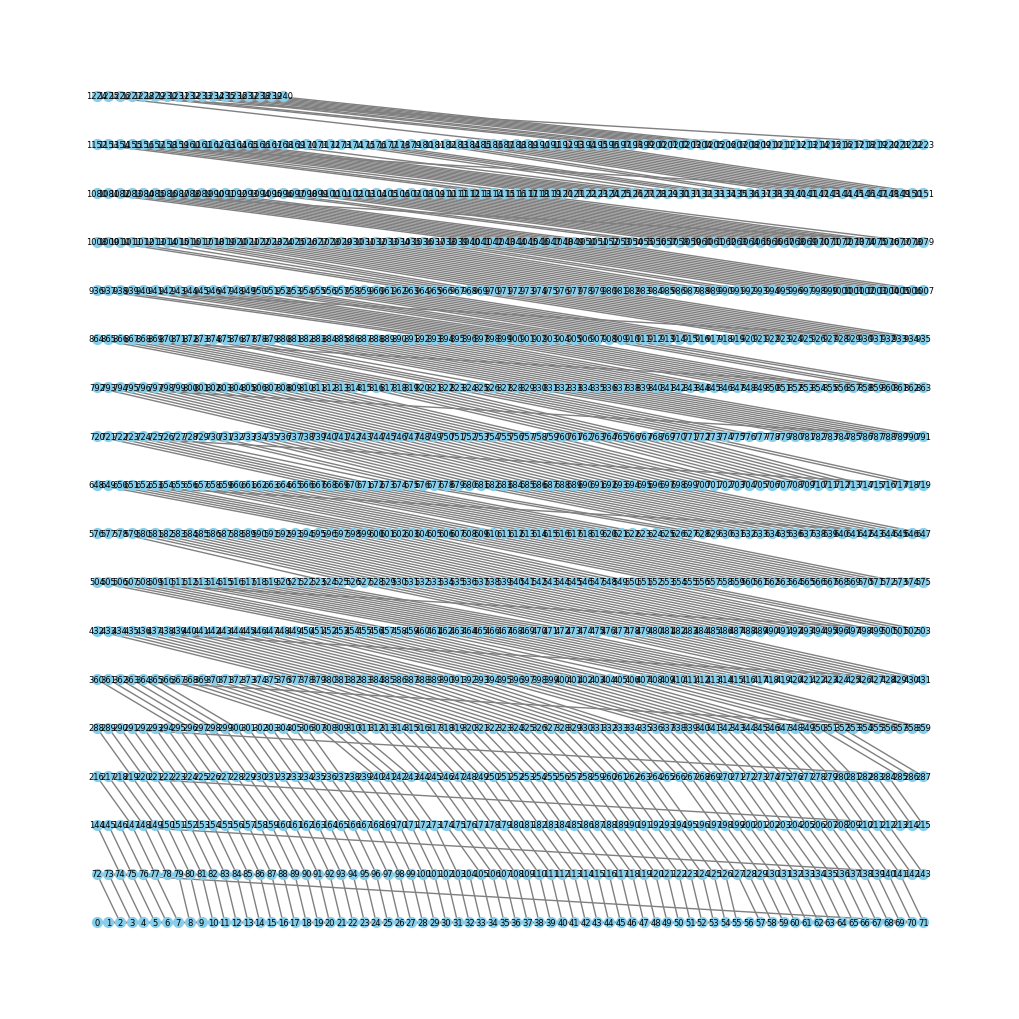

In [11]:
data = dataset_CMIP.get(800 * 36)

G = to_networkx(data, to_undirected=True)
num_nodes = G.number_of_nodes()

# Create coordinates (positions) for the nodes. 
positions = {}
for i in range(num_nodes):
    y = i // 72  # lat
    x = i % 72   # long
    positions[i] = (x, y)

plt.figure(figsize=(10, 10))
nx.draw(G, pos=positions, with_labels=True, node_color='skyblue', node_size=50, edge_color='gray', font_size=6)
plt.show()

In [31]:
print(np.isnan(raw_CMIP['va'].isel(year=337, month=31).to_numpy()).sum())
print(torch.load('337_31.pt'))

0
Data(x=[1728, 4], edge_index=[2, 6720])


/tmp/ipykernel_190457/625773073.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  print(torch.load('337_31.pt'))


In [28]:
from utils.data_utils import construct_adjacency_list
adj_t = construct_adjacency_list()

temp = np.stack([raw_CMIP[var].isel(year=337, month=31).to_numpy() for var in VAR_NAMES], axis=0) # 4 (var) x 24 (lat) x 72 (lon)
x = temp.transpose(1, 2, 0).reshape(-1, 4) # (24 x 72) x 4. Caution: stacks 72's on top of each other, not 24's!

# Removing NaNs (terrestial nodes)
valid_nodes = ~np.isnan(x).any(axis=1) # (24x72) bool array
filtered_x = x[valid_nodes]

valid_indices = np.where(valid_nodes)[0] # array w/ indices of valid nodes 
index_mapping = -np.ones(x.shape[0], dtype=int)  
index_mapping[valid_indices] = np.arange(len(valid_indices))  # (24x72) array, -1 if node contains NaN, new numbering for valid nodes
# original index goes in, new index or -1 comes out

filtered_edges = (index_mapping[adj_t[0]] != -1) & (index_mapping[adj_t[1]] != -1)
filtered_adj_t = index_mapping[adj_t[:, filtered_edges]]

# Creating graph from x:
g = Data(x = torch.tensor(filtered_x, dtype=torch.float32), edge_index=torch.tensor(filtered_adj_t, dtype=torch.int64))
torch.save(g, f'337_31.pt')

In [18]:
print(np.isnan(raw['va'].to_numpy()).sum())
for year in range(4400):
    if np.isnan(raw_CMIP['ua'].isel(year=year, month=0).to_numpy()).sum() != 0:
        print(year)

test = dataset_CMIP.get(800 * 36)
print(test.x.size())


0
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985
986
987
988
989
990
991
992
993
994
995
996
997
998
999
1000
1001
1002
100

/scratch/users/ethanz/enso/utils/data_utils.py:177: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  g = torch.load(osp.join(self.processed_dir, f'{year}_{month}.pt'))


### Tests: Confirming proper batch shuffling
Desired behavior: sets of 36 are shuffled but internal ordering stays the same

In [8]:
import numpy as np
from torch.utils.data import Sampler
from torch_geometric.loader import DataLoader

import numpy as np
import torch
from torch.utils.data import Sampler
from torch_geometric.data import Data, DataLoader

In [2]:
new = CMIP()
sampler = SGS(new, group_size=36, shuffle=False)
dataloader = DataLoader(new, sampler=sampler, batch_size=36)

counter = 0
b = None
for batch in dataloader:
    b = batch
    counter += 1
    if counter > 149:
        break

/scratch/users/ethanz/enso/utils/data_utils.py:158: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  g = torch.load(osp.join(self.processed_dir, f'{year}_{month}.pt'))


In [3]:
print(b)

DataBatch(x=[62208, 4], edge_index=[2, 241920], batch=[62208], ptr=[37])


In [24]:
print(b.y)
print(xr.open_dataset('data/CMIP/raw/CMIP_label.nc')['nino'].isel(year=151).to_numpy())

tensor([-3.5501e-01, -5.6253e-02,  1.2698e-01,  2.1447e-01,  3.4520e-01,
         3.5954e-01,  2.3782e-01, -3.3309e-02, -3.1511e-01, -4.2454e-01,
        -4.4501e-01, -2.5611e-01, -9.7570e-02, -6.6234e-03,  1.2040e-03,
         2.9073e-02,  2.7744e-02,  4.8429e-02, -8.2041e-02, -1.5772e-01,
        -3.2794e-01, -1.9833e-01,  3.8864e-02,  3.1286e-01,  4.2762e-01,
         4.2479e-01,  3.2421e-01,  9.7375e-02, -1.7736e-01, -5.4461e-01,
        -9.6551e-01, -1.2059e+00, -1.2905e+00, -1.2060e+00, -1.0057e+00,
        -4.6616e-01], dtype=torch.float64)
[-9.27629232e-01 -3.55005950e-01 -5.62529899e-02  1.26981676e-01
  2.14470029e-01  3.45200807e-01  3.59538645e-01  2.37818018e-01
 -3.33087593e-02 -3.15113515e-01 -4.24540609e-01 -4.45012182e-01
 -2.56110281e-01 -9.75700021e-02 -6.62339991e-03  1.20399753e-03
  2.90732086e-02  2.77442504e-02  4.84290421e-02 -8.20413604e-02
 -1.57719851e-01 -3.27944070e-01 -1.98325753e-01  3.88641171e-02
  3.12861949e-01  4.27620888e-01  4.24790025e-01  3.2421